# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import interp1d
import pitszi
import minot
from minot.ClusterTools import cluster_profile

from pitszi import physics_main as phys

import macsj0717_libs as libs

# Useful functions

In [2]:
def seaborn_1d(chains, output_fig=None, ci=0.68, truth=None, label=None,
               gridsize=100, alpha=(0.2, 0.4), xlim=None, bins=30,
               figsize=(10,10), fontsize=12, names=None,
               cols=[('blue','grey', 'orange')]):
    '''
    This function plots 1D distributions of MC chains
    
    Parameters:
    - chain (array): the chains sampling the considered parameter
    - output_fig (str): full path to output plot
    - ci (float): confidence interval considered
    - truth (float): the expected truth for overplot
    - label (str): the label of the parameter
    - gridsize (int): the size of the kde grid
    - alpha (tupple): alpha values for the histogram and the 
    overplotted confidence interval
    - figsize (tupple): the size of the figure
    - fontsize (int): the font size
    - cols (tupple): the colors of the histogram, confidence interval 
    values, and confidence interval filled region
    Output:
    - Plots
    '''
    
    fig = plt.figure(0, figsize=(8, 6))
    #----- initial plots of histograms + kde
    for idx, ch in enumerate(chains, start=0):
        sns.histplot(ch, kde=True, kde_kws={'cut':3}, color=cols[idx][0], edgecolor=cols[idx][1], 
                     alpha=alpha[0], stat='density', binrange=xlim, bins=bins)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    
    #----- show limits
    for idx, ch in enumerate(chains, start=0):
        if ci is not None:
            perc = np.percentile(ch, [100 - (100-ci*100)/2.0, 50.0, (100-ci*100)/2.0])
            # Get the KDE line for filling below
            xkde = ax.lines[idx].get_xdata()
            ykde = ax.lines[idx].get_ydata()
            wkeep = (xkde < perc[0]) * (xkde > perc[2])
            xkde_itpl = np.append(np.append(perc[2], xkde[wkeep]), perc[0])
            itpl = interp1d(xkde, ykde)
            ykde_itpl = itpl(xkde_itpl)
            perc_max = itpl(perc)
            
            ax.vlines(perc[0], 0.0, perc_max[0], linestyle='--', color=cols[idx][1])
            ax.vlines(perc[2], 0.0, perc_max[2], linestyle='--', color=cols[idx][1])
            
            if idx == 0:
                ax.vlines(perc[1], 0.0, perc_max[1], linestyle='-.', label='Median', color=cols[idx][1])
            else:
                ax.vlines(perc[1], 0.0, perc_max[1], linestyle='-.', color=cols[idx][1])
            if names is not None:
                ax.fill_between(xkde_itpl, 0*ykde_itpl, y2=ykde_itpl, alpha=alpha[1], 
                                color=cols[idx][2], label=names[idx])
            else:
                ax.fill_between(xkde_itpl, 0*ykde_itpl, y2=ykde_itpl, alpha=alpha[1], 
                                color=cols[idx][2])
    # Show expected value                        
    if truth is not None:
        ax.vlines(truth, 0, ymax, linestyle=':', label='Truth', color='k')
    
    # label and ticks
    if label is not None:
        ax.set_xlabel(label)
        ax.set_ylabel('P('+label+')')
    ax.set_yticks([])
    ax.set_ylim(0, ymax)
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
               
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
               
    ax.legend(fontsize=fontsize)
    
    if output_fig is not None:
        plt.savefig(output_fig, bbox_inches = 'tight')

In [3]:
#----- Init the objects to have access to prior function only
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(4*u.arcmin, 4*u.arcsec, 0.1)
cl_data  = libs.def_data(cl_img, cl_head, cl_noise, cl_mask, 18.2*u.arcsec, libs.get_TF(), '', 1)
cl_model = pitszi.Model(RA=109.3806*u.deg, Dec=37.7583*u.deg, silent=True)
cl_model.map_header = cl_head
cl_Finfer = pitszi.InferenceFluctuation(cl_data, cl_model, silent=True)

def fake_chains_curvefit(parinfo, popt, pcov, Nsample=10000):
    par_chains = np.zeros((Nsample, len(popt)))
    isamp = 0
    while isamp < Nsample:
        param = np.random.multivariate_normal(popt, pcov)
        cond = np.isfinite(cl_Finfer.prior_fluctuation(param, parinfo))
        if cond:
            par_chains[isamp,:] = param
            isamp += 1
    return par_chains[np.newaxis]

# Parameters

In [4]:
base = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

In [5]:
include_scatter = False
Nmc = 1000

cl_redshift = 0.546
cl_M500     = 18.1*1e14*u.Msun

Tgas = 15*u.keV
cs = phys.sound_speed(Tgas)
print(cs)

1981.3508758974326 km / s


# Get the fit data

In [6]:
with open(base+'Pk_constraint_RM1_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist1 = np.load(f, allow_pickle=True)
    popt1 = np.load(f, allow_pickle=True)
    pcov1 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM2_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist2 = np.load(f, allow_pickle=True)
    popt2 = np.load(f, allow_pickle=True)
    pcov2 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM3_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist3 = np.load(f, allow_pickle=True)
    popt3 = np.load(f, allow_pickle=True)
    pcov3 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM4_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist4 = np.load(f, allow_pickle=True)
    popt4 = np.load(f, allow_pickle=True)
    pcov4 = np.load(f, allow_pickle=True)
with open(base+'Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', 'rb') as f:
    plist5 = np.load(f, allow_pickle=True)
    popt5 = np.load(f, allow_pickle=True)
    pcov5 = np.load(f, allow_pickle=True)

# Analysis

In [7]:
#===== Get parameter chains for each RM 
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[50, 5000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
    'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
}

parlist = [popt1, popt2, popt3, popt4, popt5]
covlist = [pcov1, pcov2, pcov3, pcov4, pcov5]
ell     = [False, False, True, True, True]

chains1 = fake_chains_curvefit(fitpar_pk3d, parlist[0], covlist[0], Nsample=Nmc)
chains2 = fake_chains_curvefit(fitpar_pk3d, parlist[1], covlist[1], Nsample=Nmc)
chains3 = fake_chains_curvefit(fitpar_pk3d, parlist[2], covlist[2], Nsample=Nmc)
chains4 = fake_chains_curvefit(fitpar_pk3d, parlist[3], covlist[3], Nsample=Nmc)
chains5 = fake_chains_curvefit(fitpar_pk3d, parlist[4], covlist[4], Nsample=Nmc)

/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/minot/ClusterTools/cluster_profile.py:82: RuntimeWarning: invalid value encountered in power
  term2 = (r3d_kpc / r_c)**(-alpha/2.0)
/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/minot/ClusterTools/cluster_profile.py:83: RuntimeWarning: invalid value encountered in power
  term3 = (1 + (r3d_kpc / r_s)**gamma)**(-epsilon/2.0/gamma)


[ 4.90402506e-03  5.49708472e+02  2.53248700e+00  4.08262407e+02
 -7.98488018e+00  6.44711776e-01]


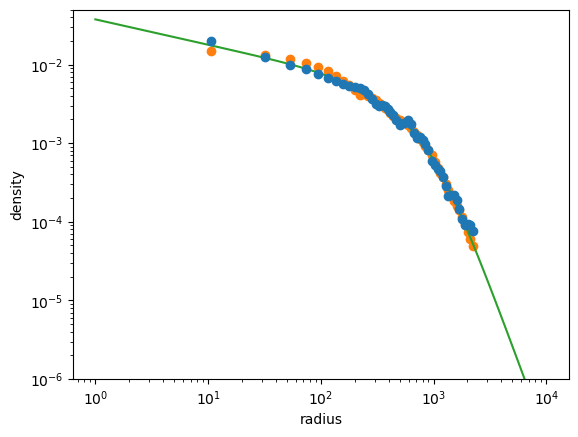

In [8]:
#===== X-ray density profile data
# Get the data
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/Xray/densprof_macsj0717.fits')
dat = hdul[1].data
wok = dat['R'] > 0

# SVM fit
def fitfunc(r3d, n0, rc, beta, rs, epsilon, alpha):
    return cluster_profile.svm_model(r3d, n0, rc, beta, rs, 3, epsilon, alpha)

pars, parscov = curve_fit(fitfunc, dat['R'][wok], dat['DENS'][wok], 
                          sigma=dat['ERRMDENS'][wok], absolute_sigma=True)
print(pars)

# Check the correct interpolation
plt.errorbar(dat['R'], dat['DENS'], dat['ERRMDENS'], marker='o', ls='')
plt.plot(dat['R'], savgol_filter(dat['DENS'], 21,2), marker='o', ls='')
plt.plot(np.logspace(0,4,100), fitfunc(np.logspace(0,4,100), *pars))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('density')
plt.xlabel('radius')
plt.ylim(1e-6,5e-2)

# Xray model
rad_x = np.logspace(0,4,1000)*u.kpc
n_x = fitfunc(np.logspace(0,4,1000), *pars)*u.cm**-3

Text(0, 0.5, 'HSE mass (Msun)')

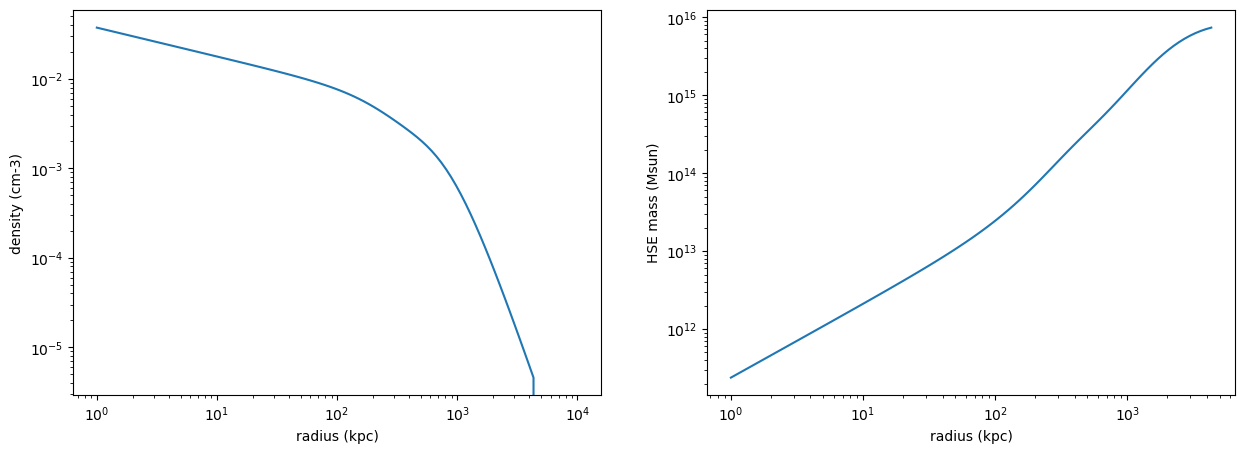

In [9]:
#===== Defines a pure hydro model
cl_model = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
cl_model.set_pressure_gas_universal_param('A10MD') # Set to model RM1
cl_model.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}

plt.figure(1, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
r,n = cl_model.get_density_gas_profile()
plt.loglog(r, n)
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm-3)')

ax = plt.subplot(1, 2, 2)
r,m = cl_model.get_hse_mass_profile()
plt.loglog(r, m)
plt.xlabel('radius (kpc)')
plt.ylabel('HSE mass (Msun)')

In [10]:
def extract_mass_prof(chain, case='sum'):
    
    k3d = np.logspace(-4,-1,100)*u.kpc**-1
    radius = np.logspace(1,4,1000)*u.kpc    # large number of points needed for user-provided model precision
    
    Nmc = len(chain)
    MC_b_hse500  = np.zeros((Nmc))
    MC_b_hse2500 = np.zeros((Nmc))
    MC_Mcorr     = np.zeros((Nmc, len(radius)))
    for imc in range(Nmc):
        # Get the X profile
        M3d_r, M3d_r_err = phys.sigma_rad_to_M3d_Z23(chain[imc,0], radius, cl_model.R500, 
                                                     state='unrelaxed', case=case, ret_err=True)
        if include_scatter: 
            X = phys.Eturb_over_Etherm(M3d_r + np.random.normal(0, 1)*M3d_r_err)
        else:
            X = phys.Eturb_over_Etherm(M3d_r)
        
        # Define the corrected cluster model
        cl_model_c = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
        cl_model_c.set_pressure_gas_universal_param('A10MD') # Set to model RM1
        r, p = cl_model_c.get_pressure_gas_profile(radius)
        cl_model_c.pressure_gas_model = {'name':'User','radius':r,'profile':p*(1+X)}
        cl_model_c.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}

        # Get the masses at delta and biasses
        R500_0, M500_0 = cl_model.get_mdelta_from_profile(500)
        R500_c, M500_c = cl_model_c.get_mdelta_from_profile(500)
        MC_b_hse500[imc] = 1 - M500_0/M500_c
        
        R2500_0, M2500_0 = cl_model.get_mdelta_from_profile(2500)
        R2500_c, M2500_c = cl_model_c.get_mdelta_from_profile(2500)
        MC_b_hse2500[imc] = 1 - M2500_0/M2500_c
        
        # Get the mass profile
        _, m_c_prof = cl_model_c.get_hse_mass_profile(radius)
        MC_Mcorr[imc,:] = m_c_prof.value

        if imc % 500 == 0: print('Number of MC:', imc, '/', Nmc)
            
    #----- Compute bias percentiles
    Nnan500 = np.sum(np.isnan(MC_b_hse500))
    Nnan2500 = np.sum(np.isnan(MC_b_hse2500))
    print('Number of Nan 500: ', Nnan500, ' ; ', 'Number of Nan 2500: ', Nnan2500)
    perc = np.nanpercentile(MC_b_hse2500, [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('HSE bias 2500: ', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    perc = np.nanpercentile(MC_b_hse500, [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0])
    print('HSE bias 500: ', perc[1],'+', perc[2]-perc[1], '-', perc[1]-perc[0])
    print('')
    
    #----- Compute mass profiles percentiles
    perc = np.nanpercentile(MC_Mcorr, [(100-0.68*100)/2.0, 50.0, 100 - (100-0.68*100)/2.0], axis=0)
    m_l, m_c, m_u = perc[0], perc[1], perc[2]
        
    return MC_b_hse2500, MC_b_hse500, m_l, m_c, m_u

In [11]:
r, m = cl_model.get_hse_mass_profile(np.logspace(1,4,1000)*u.kpc)
m = m.value

bhse2500_1, bhse500_1, m1_l, m1_c, m1_u = extract_mass_prof(chains1[0], case='sum')
bhse2500_2, bhse500_2, m2_l, m2_c, m2_u = extract_mass_prof(chains2[0], case='sum')
bhse2500_3, bhse500_3, m3_l, m3_c, m3_u = extract_mass_prof(chains3[0], case='sum')
bhse2500_4, bhse500_4, m4_l, m4_c, m4_u = extract_mass_prof(chains4[0], case='sum')
bhse2500_5, bhse500_5, m5_l, m5_c, m5_u = extract_mass_prof(chains5[0], case='sum')

Number of MC: 0 / 1000
Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.3397280398066069 + 0.007622054222291119 - 0.010234220795318383
HSE bias 500:  0.4143643512773935 + 0.00568556740064724 - 0.007513682155394219

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.2986516476550394 + 0.004344538757766692 - 0.0043072683383205135
HSE bias 500:  0.38356947466049646 + 0.0032313384785548904 - 0.003328012476102038

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.2935470379124741 + 0.004870250297969392 - 0.004547832427793719
HSE bias 500:  0.37960796141860226 + 0.0037857561830053066 - 0.0036532607476388868

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.3044037585443521 + 0.008329483147147099 - 0.009844881079424994
HSE bias 500:  0.3878370557771299 + 0.006450920430460416 - 0.0074255280752872355

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  44  ;  Number of Nan 2500:  0
HSE bias 2500:  0.2415971237819281 + 0.019312915381758 - 0.022432023542911628
HSE bias 500:  0.3397420294472137 + 0.014736528977681351 - 0.02042673150325175



/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


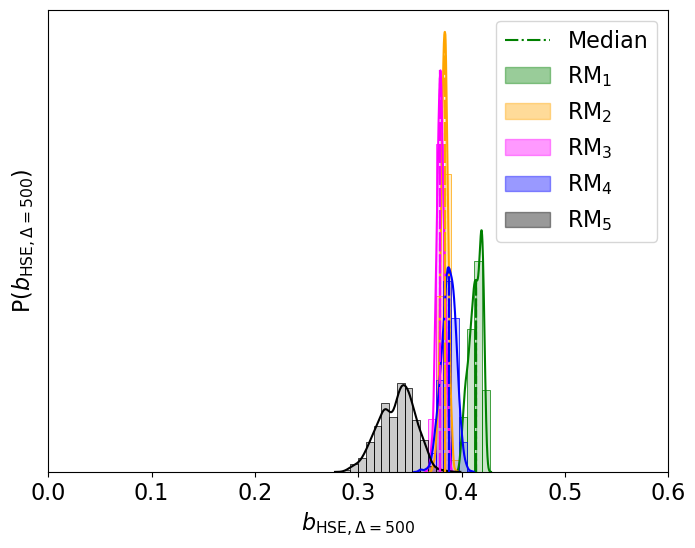

In [12]:
seaborn_1d(np.array([bhse500_1, bhse500_2, bhse500_3, bhse500_4, bhse500_5]), 
           output_fig=base+'/PDF_bHSE500_scatter'+str(include_scatter)+'_caseSum.pdf', ci=0.0, truth=None, label=r'$b_{{\rm HSE}, \Delta=500}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0.,0.6], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

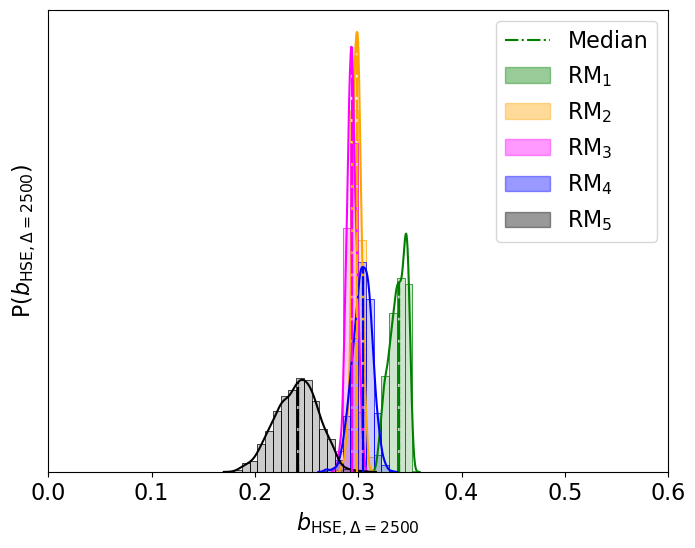

In [13]:
seaborn_1d(np.array([bhse2500_1, bhse2500_2, bhse2500_3, bhse2500_4, bhse2500_5]), 
           output_fig=base+'/PDF_bHSE2500_scatter'+str(include_scatter)+'_caseSum.pdf', ci=0.0, truth=None, label=r'$b_{{\rm HSE}, \Delta=2500}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0.,0.6], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

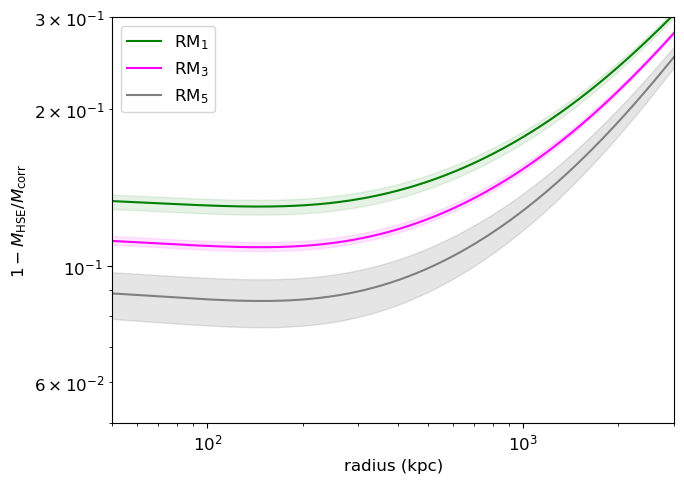

In [14]:
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.loglog(r,1-m/m1_c, color='green', label='RM$_1$')
plt.fill_between(r.value, 1-m/m1_u, 1-m/m1_l, color='green', alpha=0.1)

#plt.loglog(r,1-m/m2_c, color='orange', label='RM$_2$')
#plt.fill_between(r.value, 1-m/m2_u, 1-m/m2_l, color='orange', alpha=0.1)

plt.loglog(r,1-m/m3_c, color='magenta', label='RM$_3$')
plt.fill_between(r.value, 1-m/m3_u, 1-m/m3_l, color='magenta', alpha=0.1)

#plt.loglog(r,1-m/m4_c, color='blue', label='RM$_4$')
#plt.fill_between(r.value, 1-m/m4_u, 1-m/m4_l, color='blue', alpha=0.1)

plt.loglog(r,1-m/m5_c, color='grey', label='RM$_5$')
plt.fill_between(r.value, 1-m/m5_u, 1-m/m5_l, color='k', alpha=0.1)

plt.xlim(50,3000)
plt.ylim(0.05,0.3)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$1 - M_{\rm HSE}/M_{\rm corr}$')
plt.legend()
plt.savefig(base+'NT_Bhse_sum_scatter'+str(include_scatter)+'.pdf')

In [15]:
r, m = cl_model.get_hse_mass_profile(np.logspace(1,4,1000)*u.kpc)
m = m.value

bhse2500_1, bhse500_1, m1_l, m1_c, m1_u = extract_mass_prof(chains1[0], case='prod')
bhse2500_2, bhse500_2, m2_l, m2_c, m2_u = extract_mass_prof(chains2[0], case='prod')
bhse2500_3, bhse500_3, m3_l, m3_c, m3_u = extract_mass_prof(chains3[0], case='prod')
bhse2500_4, bhse500_4, m4_l, m4_c, m4_u = extract_mass_prof(chains4[0], case='prod')
bhse2500_5, bhse500_5, m5_l, m5_c, m5_u = extract_mass_prof(chains5[0], case='prod')

Number of MC: 0 / 1000
Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.3478802087298726 + 0.006717893869975677 - 0.010037837037205566
HSE bias 500:  0.4125665412903683 + 0.006399578497823577 - 0.009426423769055725

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.3038075247645842 + 0.004684334862431305 - 0.005240629610684888
HSE bias 500:  0.37012692925529 + 0.004556665096808632 - 0.005233228768075138

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.2981175278829994 + 0.005435520487809042 - 0.005378694538515139
HSE bias 500:  0.3644379775244681 + 0.005438214205791603 - 0.005371520648926431

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  0  ;  Number of Nan 2500:  0
HSE bias 2500:  0.3106001085859048 + 0.009756877384775209 - 0.011257510401995297
HSE bias 500:  0.37676590135290255 + 0.00956395154252504 - 0.011088181245294593

Number of MC: 0 / 1000


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Number of MC: 500 / 1000
Number of Nan 500:  13  ;  Number of Nan 2500:  0
HSE bias 2500:  0.2212338470710591 + 0.03186533567613775 - 0.04511029276798162
HSE bias 500:  0.2834142848386051 + 0.033441194390700035 - 0.05122772698608538



/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/Users/adam/Project/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


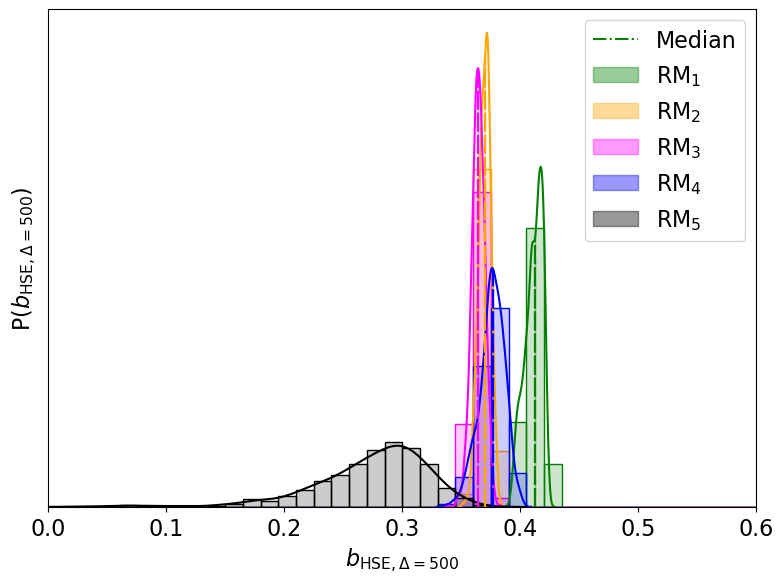

In [16]:
seaborn_1d(np.array([bhse500_1, bhse500_2, bhse500_3, bhse500_4, bhse500_5]), 
           ci=0.0, truth=None, label=r'$b_{{\rm HSE}, \Delta=500}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0.,0.6], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

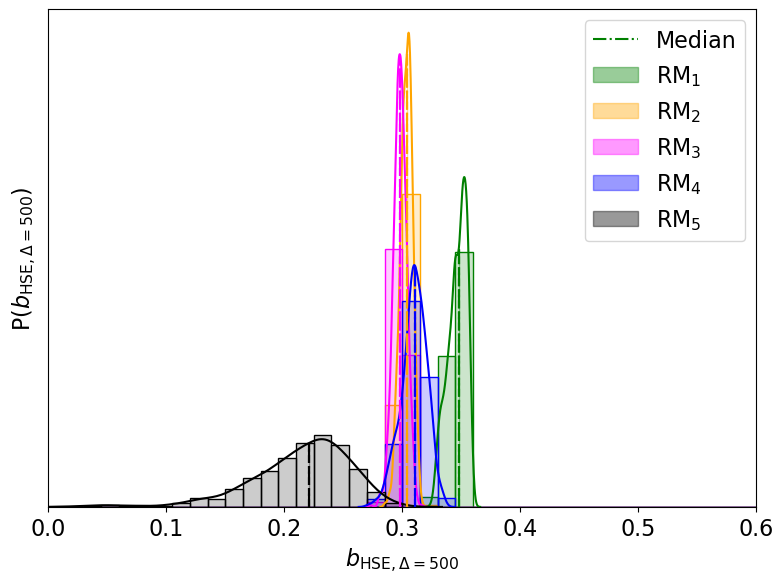

In [17]:
seaborn_1d(np.array([bhse2500_1, bhse2500_2, bhse2500_3, bhse2500_4, bhse2500_5]), 
           ci=0.0, truth=None, label=r'$b_{{\rm HSE}, \Delta=2500}$',
           names=['RM$_1$', 'RM$_2$', 'RM$_3$', 'RM$_4$', 'RM$_5$'],
           alpha=(0.2, 0.4), 
           figsize=(10,10), fontsize=16, xlim=[0.,0.6], bins=80,
           cols=[('green','green','green'), 
                 ('orange','orange','orange'), 
                 ('magenta','magenta','magenta'), 
                 ('blue','blue','blue'), 
                 ('k','k','k')])

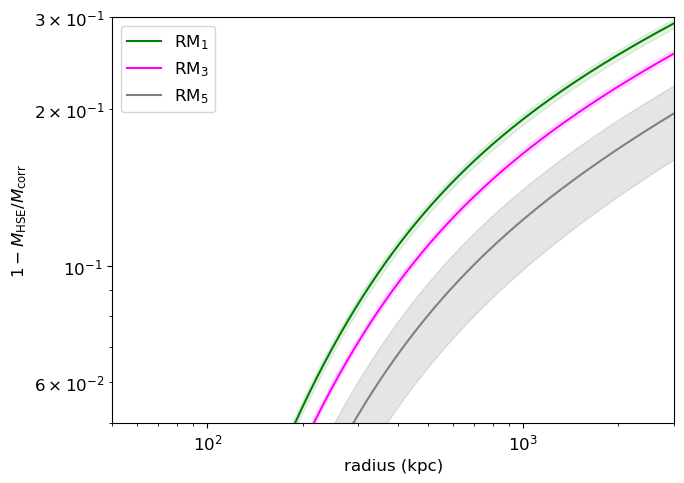

In [18]:
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.loglog(r,1-m/m1_c, color='green', label='RM$_1$')
plt.fill_between(r.value, 1-m/m1_u, 1-m/m1_l, color='green', alpha=0.1)

#plt.loglog(r,1-m/m2_c, color='orange', label='RM$_2$')
#plt.fill_between(r.value, 1-m/m2_u, 1-m/m2_l, color='orange', alpha=0.1)

plt.loglog(r,1-m/m3_c, color='magenta', label='RM$_3$')
plt.fill_between(r.value, 1-m/m3_u, 1-m/m3_l, color='magenta', alpha=0.1)

#plt.loglog(r,1-m/m4_c, color='blue', label='RM$_4$')
#plt.fill_between(r.value, 1-m/m4_u, 1-m/m4_l, color='blue', alpha=0.1)

plt.loglog(r,1-m/m5_c, color='grey', label='RM$_5$')
plt.fill_between(r.value, 1-m/m5_u, 1-m/m5_l, color='k', alpha=0.1)

plt.xlim(50,3000)
plt.ylim(0.05,0.3)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$1 - M_{\rm HSE}/M_{\rm corr}$')
plt.legend()
plt.savefig(base+'NT_Bhse_prod_scatter'+str(include_scatter)+'.pdf')